In [30]:
import os
from tqdm import tqdm
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.manifold import MDS

COUNTRIES_PATH = os.path.join("images", "png", "countries")
png_paths = [os.path.join(COUNTRIES_PATH, nm) for nm in os.listdir(COUNTRIES_PATH)]

with open("code2country.json", "r") as f:
    code2country = json.load(f)

country2code = {v: k for k, v in code2country.items()}

In [31]:
def calc_color_distrib(code, threshold, plotting=False):
    path = os.path.join(COUNTRIES_PATH, code + ".png")
    img = np.array(Image.open(path))[:,:,:3]
    h, w, c = img.shape
    pixels = (img.reshape((-1,3)) / 255).round(2)

    # Get the unique colors and their counts
    colors = np.unique(pixels, axis=0, return_counts=True)
    colors = {tuple(pixel):round(count/len(pixels)*100) for pixel,count in sorted(zip(*colors), key=lambda x: x[1], reverse=True) if count/len(pixels) > threshold}

    if plotting:
        plt.pie(colors.values(), labels=colors.values(), colors=colors.keys())
        plt.show()
        print(colors)
        plt.imshow(pixels.reshape(h,w,c))
        plt.axis("Off")
        plt.show()

    return colors

def calc_color_distribs(threshold=0.05):
    color_distribs = {}

    for code in tqdm(code2country.keys()):
        color_distribs[code] = calc_color_distrib(code, threshold)

    # Save the color distributions to json file named "color_distribs.json"
    # First, convert the inner keys to strings
    color_distribs_str = {k:{str(kk):vv for kk,vv in v.items()} for k,v in color_distribs.items()}
    with open("color_distribs_new.json", "w") as f:
        json.dump(color_distribs_str, f)

    return color_distribs

calc_color_distribs(threshold=0.01)

# calc_color_distrib(country2code["andorra"], 0.01, plotting=True)

100%|██████████| 197/197 [02:09<00:00,  1.52it/s]


{'afg': {(1.0, 1.0, 1.0): 88.0, (0.0, 0.0, 0.0): 9.0},
 'ago': {(0.8, 0.04, 0.18): 48.0, (0.0, 0.0, 0.0): 47.0, (1.0, 0.8, 0.0): 4.0},
 'alb': {(1.0, 0.0, 0.0): 87.0, (0.0, 0.0, 0.0): 12.0},
 'and': {(0.06, 0.02, 0.62): 32.0,
  (0.84, 0.0, 0.2): 32.0,
  (1.0, 0.87, 0.0): 27.0,
  (0.78, 0.67, 0.46): 4.0,
  (0.84, 0.17, 0.12): 1.0},
 'are': {(0.0, 0.0, 0.0): 25.0,
  (0.0, 0.45, 0.18): 25.0,
  (1.0, 0.0, 0.0): 25.0,
  (1.0, 1.0, 1.0): 25.0},
 'arg': {(0.45, 0.67, 0.87): 66.0, (1.0, 1.0, 1.0): 31.0},
 'arm': {(0.0, 0.2, 0.63): 33.0,
  (0.85, 0.0, 0.07): 33.0,
  (0.95, 0.66, 0.0): 33.0},
 'atg': {(0.81, 0.07, 0.15): 50.0,
  (0.0, 0.0, 0.0): 26.0,
  (0.0, 0.45, 0.78): 11.0,
  (1.0, 1.0, 1.0): 8.0,
  (0.99, 0.82, 0.09): 5.0},
 'aus': {(0.0, 0.13, 0.41): 79.0,
  (1.0, 1.0, 1.0): 11.0,
  (0.89, 0.0, 0.17): 9.0},
 'aut': {(0.78, 0.06, 0.18): 67.0, (1.0, 1.0, 1.0): 33.0},
 'aze': {(0.0, 0.71, 0.89): 33.0,
  (0.31, 0.62, 0.18): 33.0,
  (0.94, 0.2, 0.25): 32.0,
  (1.0, 1.0, 1.0): 2.0},
 'bdi': {(1.

In [5]:
# load the color distributions from json file named "color_distribs.json"
with open("color_distribs.json", "r") as f:
    color_distrs = json.load(f)

# convert the inner keys back to tuples
color_distrs = {k:{tuple(eval(kk)):vv for kk,vv in v.items()} for k,v in color_distrs.items()}
color_distrs

{'ago': {(0.8, 0.04, 0.18): 48.0, (0.0, 0.0, 0.0): 47.0, (1.0, 0.8, 0.0): 4.0},
 'alb': {(1.0, 0.0, 0.0): 87.0, (0.0, 0.0, 0.0): 12.0},
 'and': {(0.06, 0.02, 0.62): 32.0,
  (0.84, 0.0, 0.2): 32.0,
  (1.0, 0.87, 0.0): 27.0,
  (0.78, 0.67, 0.46): 4.0,
  (0.84, 0.17, 0.12): 1.0},
 'are': {(0.0, 0.0, 0.0): 25.0,
  (0.0, 0.45, 0.18): 25.0,
  (1.0, 0.0, 0.0): 25.0,
  (1.0, 1.0, 1.0): 25.0},
 'arg': {(0.45, 0.67, 0.87): 66.0, (1.0, 1.0, 1.0): 31.0},
 'arm': {(0.0, 0.2, 0.63): 33.0,
  (0.85, 0.0, 0.07): 33.0,
  (0.95, 0.66, 0.0): 33.0},
 'atg': {(0.81, 0.07, 0.15): 50.0,
  (0.0, 0.0, 0.0): 26.0,
  (0.0, 0.45, 0.78): 11.0,
  (1.0, 1.0, 1.0): 8.0,
  (0.99, 0.82, 0.09): 5.0},
 'aus': {(0.0, 0.13, 0.41): 79.0,
  (1.0, 1.0, 1.0): 11.0,
  (0.89, 0.0, 0.17): 9.0},
 'aut': {(0.78, 0.06, 0.18): 67.0, (1.0, 1.0, 1.0): 33.0},
 'aze': {(0.0, 0.71, 0.89): 33.0,
  (0.31, 0.62, 0.18): 33.0,
  (0.94, 0.2, 0.25): 32.0,
  (1.0, 1.0, 1.0): 2.0},
 'bdi': {(1.0, 1.0, 1.0): 34.0,
  (0.26, 0.69, 0.16): 34.0,
  (0.78

In [6]:
def RGB2Lab_(RGB):
    """Convert RGB color vector into CIE Lab color space. Returns a 3-element vector, Lab, which contains the L*, a*, and b* values, 
    which range from 0 to 100, -128 to 127, and -128 to 127, respectively."""
    # Copilot added this link lol
    # https://stackoverflow.com/questions/13405956/convert-an-image-rgb-lab-with-python/13424079#13424079

    # RGB values lie between 0 to 1.0
    assert 0 <= RGB[0] <= 1.0 and 0 <= RGB[1] <= 1.0 and 0 <= RGB[2] <= 1.0

    # Conversion matrix
    M = np.array([[0.412453, 0.357580, 0.180423],
                  [0.212671, 0.715160, 0.072169],
                  [0.019334, 0.119193, 0.950227]])

    # Conversion
    XYZ = np.dot(M, RGB)
    XYZ = XYZ / np.array([0.950456, 1.0, 1.088754])

    # Threshold
    XYZ[XYZ > 0.008856] = XYZ[XYZ > 0.008856] ** (1 / 3)
    XYZ[XYZ <= 0.008856] = 7.787 * XYZ[XYZ <= 0.008856] + 16 / 116

    # Conversion to Lab
    Lab = np.zeros_like(XYZ)
    Lab[:, 0] = 116 * XYZ[:, 1] - 16
    Lab[:, 1] = 500 * (XYZ[:, 0] - XYZ[:, 1])
    Lab[:, 2] = 200 * (XYZ[:, 1] - XYZ[:, 2])

    return Lab

# Single 1D vector version of the above function
def RGB2Lab(RGB):
    """Convert RGB color vector into CIE Lab color space. Returns a 3-element vector, Lab, which contains the L*, a*, and b* values, 
    which range from 0 to 100, -128 to 127, and -128 to 127, respectively."""
    if Lab_lookup:
        return Lab_dict[tuple(RGB)]

    # RGB values lie between 0 to 1.0
    assert 0 <= RGB[0] <= 1.0 and 0 <= RGB[1] <= 1.0 and 0 <= RGB[2] <= 1.0

    # Conversion matrix
    M = np.array([[0.412453, 0.357580, 0.180423],
                  [0.212671, 0.715160, 0.072169],
                  [0.019334, 0.119193, 0.950227]])

    # Conversion
    XYZ = np.dot(M, RGB)
    XYZ = XYZ / np.array([0.950456, 1.0, 1.088754])

    # Threshold
    XYZ[XYZ > 0.008856] = XYZ[XYZ > 0.008856] ** (1 / 3)
    XYZ[XYZ <= 0.008856] = 7.787 * XYZ[XYZ <= 0.008856] + 16 / 116

    # Conversion to Lab
    L = 116 * XYZ[1] - 16
    a = 500 * (XYZ[0] - XYZ[1])
    b = 200 * (XYZ[1] - XYZ[2])

    return np.array([L, a, b])


def RGB2OKLab(RGB):
    """Convert RGB color vector into OKLab color space. Returns a 3-element vector, OKLab, which contains the L*, a*, and b* values"""
    if OKLab_lookup:
        return OKLab_dict[tuple(RGB)]

    assert 0 <= RGB[0] <= 1.0 and 0 <= RGB[1] <= 1.0 and 0 <= RGB[2] <= 1.0

    # Linearize RGB values
    RGB = RGB ** 2.2

    # Convert to linear sRGB
    M = np.array([[0.4124564, 0.3575761, 0.1804375],
                    [0.2126729, 0.7151522, 0.0721750],
                    [0.0193339, 0.1191920, 0.9503041]])
    XYZ = np.dot(M, RGB)

    # Convert linear sRGB to OKLab
    M2 = np.array([[0.4121656120, 0.5362752080, 0.0514575653],
                    [0.2118591070, 0.6807189584, 0.1074065790],
                    [0.0883097947, 0.2818474174, 0.6302613616]])
    L, M, S = np.dot(M2, XYZ)
    
    # Nonlinearize OKLab values
    L = L ** (1/3)
    M = M ** (1/3)
    S = S ** (1/3)

    return np.array([L, M, S])


def RGB2HSL(RGB):
    """Convert RGB color vector into HSL color space. Returns a 3-element vector, HSL, which contains the H, S, and L values, 
    which range from 0 to 360, 0 to 1.0, and 0 to 1.0, respectively."""
    if HSL_lookup:
        return HSL_dict[tuple(RGB)]

    # RGB values lie between 0 to 1.0
    assert 0 <= RGB[0] <= 1.0 and 0 <= RGB[1] <= 1.0 and 0 <= RGB[2] <= 1.0

    # Conversion
    Cmax = np.max(RGB)
    Cmin = np.min(RGB)
    delta = Cmax - Cmin

    # Hue
    if delta == 0:
        H = 0
    elif Cmax == RGB[0]:
        H = 60 * (((RGB[1] - RGB[2]) / delta) % 6)
    elif Cmax == RGB[1]:
        H = 60 * (((RGB[2] - RGB[0]) / delta) + 2)
    elif Cmax == RGB[2]:
        H = 60 * (((RGB[0] - RGB[1]) / delta) + 4)

    # Lightness
    L = (Cmax + Cmin) / 2

    # Saturation
    if delta == 0:
        S = 0
    else:
        S = delta / (1 - np.abs(2 * L - 1))

    return np.array([H, S, L])

In [7]:
# Make dictionary for looking up Lab color from RGB color for each color in the color distributions
Lab_lookup = False
Lab_dict = {} # {RGB: Lab}
for code, colors in color_distrs.items():
    for color in colors:
        if color not in Lab_dict:
            Lab_dict[color] = RGB2Lab(np.array(color))

Lab_lookup = True
len(Lab_dict)

285

In [8]:
# Same for OKLab
OKLab_lookup = False
OKLab_dict = {} # {RGB: OKLab}
for code, colors in color_distrs.items():
    for color in colors:
        if color not in OKLab_dict:
            OKLab_dict[color] = RGB2OKLab(np.array(color))

OKLab_lookup = True

In [9]:
# Same for HSL
HSL_lookup = False
HSL_dict = {} # {RGB: HSL}
for code, colors in color_distrs.items():
    for color in colors:
        if color not in HSL_dict:
            HSL_dict[color] = RGB2HSL(np.array(color))

HSL_lookup = True

In [23]:
"""
To calculate color distribution similarity, we can use the following algorithm:
For each country, we have a color distribution, which is a dictionary of colors and their percentages
(We can't calculate the similarity between two color distributions by calculating the cosine similarity between the two vectors of percentages because the colors are different.)
for country1 in countries:
    for country2 in countries:
        if country1 == country2:
            continue
            
        similarity = 0
        for color1, percent1 in country1.color_distrib.items():
            for color2, percent2 in country2.color_distrib.items():
                cosine_sim = cosine_similarity(color1, color2)
                similarity += cosine_sim * percent1 * percent2

But maybe it actually makes more sense to have a distance value where you start with one and for each color that is lacking or added in the other flag you add distance.
for country1 in countries:
    for country2 in countries:
        if country1 == country2:
            continue
            
        distance = 0
        for color1, percent1 in country1.color_distrib.items():
            # get the color in country2 that is most similar to color1
            color2 = get_most_similar_color(color1, country2.color_distrib)
            distance += euclidean_distance(color1, color2) * min(percent1, percent2)
fault with this method: let's say you have a blue flag with a little yellow star. Another identical flag with a slightly different tint of blue would get a distance based
on that blue surface. Another flag entirely orange with a little white (which is closer to the blue than the orange) would only get a tiny distance based on
the little white and the little yellow. Maybe if instead of the minimum of the percentages, we take the difference, no because then a little spot of colour could have a major effect.
"""

def cosine_similarity(color1, color2):
    """Calculate the cosine similarity between two colors"""
    # Clip the values to avoid division by zero
    color1 = np.clip(color1, 0.0001, 1)
    color2 = np.clip(color2, 0.0001, 1)
    return np.dot(color1, color2) / (np.linalg.norm(color1) * np.linalg.norm(color2))

def euclidean_distance(color1, color2):
    """Calculate the euclidean distance between two colors"""
    return np.linalg.norm(color1 - color2)

def euclidean_similarity(color1, color2):
    """Calculate the euclidean similarity between two colors"""
    # 1.73 is the maximum euclidean distance between two RGB colors (sqrt(3))
    return 1 - euclidean_distance(color1, color2) / 1.73

def euclidean_distance_Lab(color1, color2, weight=1):
    """Calculate the euclidean distance between two colors in the Lab color space. The L component is weighted by the given weight."""
    diff = RGB2Lab(color1) - RGB2Lab(color2)
    return np.linalg.norm(np.array([weight * diff[0], diff[1], diff[2]]))

"""One problem with Lab is that lightblue is seen as closer to white than normal blue"""

def euclidean_similarity_Lab(color1, color2, weight=2.55):
    """Calculate the euclidean similarity between two colors in the Lab color space"""
    if weight == 2.55: # for faster computation at default
        max_dist = 441.7
    elif weight == 1:
        max_dist = 374.2
    else:
        max_dist = np.sqrt((weight * 100) ** 2 + 255 ** 2 + 255 ** 2)
    return 1 - euclidean_distance_Lab(color1, color2, weight) / max_dist

def HSL_dist(color1, color2, weights=[1.5,1,1]):
    """Computes a custom distance between two colors in HSL space"""
    color1, color2 = RGB2HSL(color1), RGB2HSL(color2)

    H_dist = min(abs(color1[0]-color2[0]), 360-abs(color1[0]-color2[0]))/180
    S_dist = abs(color1[1]-color2[1])
    L_dist = abs(color1[2]-color2[2])
    return np.sqrt((weights[0]*H_dist)**2 + (weights[1]*S_dist)**2 + (weights[2]*L_dist)**2)

def HSL_similarity(color1, color2, weights=[5,1,1]):
    """Computes a custom similarity between two colors in HSL space"""
    max_dist = np.sqrt((weights[0])**2 + (weights[1])**2 + (weights[2])**2)
    return 1 - HSL_dist(color1, color2, weights) / max_dist

"""We prefer euclidean distance because it takes into account the difference in brightness, whereas cosine similarity doesn't."""

def calc_color_distrib_similarity_old(color_distr1, color_distr2, sim_fn=euclidean_similarity):
    """Calculate the similarity between two color distributions
    This is completely fucky because it gives other flags that are not that alike higher scores than the flag itself.."""
    similarity = np.array([0.]).item()
    for color1, percent1 in color_distr1.items():
        color1 = np.array(color1)
        for color2, percent2 in color_distr2.items():
            color2 = np.array(color2)
            sim = sim_fn(color1, color2)
            similarity += sim * percent1 * percent2
    return similarity

def calc_color_distrib_similarity(color_distr1, color_distr2, sim_fn=euclidean_similarity, percent_method="minimum", verbose=False):
    """Calculate the similarity between two color distributions"""
    similarity = 0.
    color_ctr = 0
    for color1, percent1 in color_distr1.items():
        color1 = np.array(color1)
        color2, neg_sim = get_nearest_color(color1, color_distr2, sim_fn, factor=-1)

        # Do a little hardcoded hack to ignore white unless it's both white, and same with black
        # This is especially important when using HSL because we emphasize the H
        from_white, to_white = np.mean(color1) >= 0.97, np.mean(color2) >= 0.97
        from_black, to_black = np.mean(color1) <= 0.03, np.mean(color2) <= 0.03
        if (from_white or from_black) and not (to_white or to_black):
            color_ctr += 0.1
            continue
        elif (to_white or to_black) and not (from_white or from_black):
            color_ctr += 1
            continue

        sim = -neg_sim
        # skewed_sim = (1-(1-sim)**0.2)
        # skewed_sim = sim**5
        skewed_sim = sim

        if percent_method == "minimum":
            factor = min(percent1, color_distr2[tuple(color2)])
        elif percent_method == "skewed":
            factor = min(percent1, color_distr2[tuple(color2)])**0.5
        elif percent_method == "uniform":
            factor = 1
        color_ctr += 1

        similarity += skewed_sim * factor

        if verbose:
            print(color_distr2)

            # Plot the two colors next to each other (as 1x1 images) with their similarity, and added to the total similarity
            plt.figure(figsize=(10,2))
            plt.subplot(1,2,1)
            # color1 has shape (3,) but imshow expects (1,1,3)
            plt.imshow(color1.reshape(1,1,3))
            plt.title(f"Similarity: {sim:.2f}")

            plt.subplot(1,2,2)
            plt.imshow(color2.reshape(1,1,3))
            plt.title(f"Skewed Similarity: {skewed_sim:.2f}")
            
    if percent_method == "uniform":
        similarity /= max(1,color_ctr)

    return similarity

def calc_color_distrib_similarity_matrix(color_distrs, distr_sim_fn=calc_color_distrib_similarity, sim_fn=euclidean_similarity, percent_method="minimum"):
    """Calculate the similarities between all pairs of color distributions as NxN matrix"""
    countries = list(color_distrs.keys())
    N = len(countries)
    similarity_matrix = np.zeros((N,N))
    for i in tqdm(range(N)):
        for j in range(N):
            similarity_matrix[i,j] = np.round(distr_sim_fn(color_distrs[countries[i]], color_distrs[countries[j]], sim_fn=sim_fn, percent_method=percent_method), 2)
    similarity_matrix = similarity_matrix / similarity_matrix.max()
    return similarity_matrix

def calc_color_distrib_similarity_matrix_symmetrical(color_distrs, distr_sim_fn=calc_color_distrib_similarity, sim_fn=euclidean_similarity, percent_method="minimum"):
    """Calculate the similarities between all pairs of color distributions as NxN matrix"""
    countries = list(color_distrs.keys())
    N = len(countries)
    similarity_matrix = np.zeros((N,N))
    for i in tqdm(range(N)):
        for j in range(N):
            if i > j:
                similarity_matrix[i,j] = similarity_matrix[j,i]
                continue

            similarity_matrix[i,j] = np.round(min(
                distr_sim_fn(color_distrs[countries[i]], color_distrs[countries[j]], sim_fn=sim_fn, percent_method=percent_method),
                distr_sim_fn(color_distrs[countries[j]], color_distrs[countries[i]], sim_fn=sim_fn, percent_method=percent_method)
            ), 2)
    similarity_matrix = similarity_matrix / similarity_matrix.max()
    return similarity_matrix

def get_nearest_color(color, color_distr, dist_fn=euclidean_distance, factor=1):
    """Get the color in color_distr that has the lowest euclidean distance to color. 
    Can set factor to -1 to get the color with the highest distance, or similarity if dist_fn is a similarity function."""
    min_distance = np.inf
    for color2 in color_distr.keys():
        color2 = np.array(color2)
        distance = dist_fn(color, color2) * factor
        if distance < min_distance:
            min_distance = distance
            nearest_color = color2
    return nearest_color, min_distance

def calc_color_distrib_distance(color_distr1, color_distr2, dist_fn=euclidean_distance):
    """Calculate the distance between two color distributions"""
    distance = 0
    for color1, percent1 in color_distr1.items():
        color1 = np.array(color1)
        color2, dist = get_nearest_color(color1, color_distr2, dist_fn)
        distance += dist * min(percent1, color_distr2[tuple(color2)])
    return distance

def calc_color_distrib_distance_matrix(color_distrs, dist_fn=euclidean_distance):
    """Calculate the distances between all pairs of color distributions as NxN matrix"""
    countries = list(color_distrs.keys())
    N = len(countries)
    distance_matrix = np.zeros((N,N))
    for i in tqdm(range(N)):
        for j in range(N):
            if i > j:
                distance_matrix[i,j] = distance_matrix[j,i]
                continue

            distance_matrix[i,j] = np.round(max(
                calc_color_distrib_distance(color_distrs[countries[i]], color_distrs[countries[j]], dist_fn),
                calc_color_distrib_distance(color_distrs[countries[j]], color_distrs[countries[i]], dist_fn)
            ), 2)
    distance_matrix = distance_matrix / distance_matrix.max()
    return distance_matrix

In [11]:
# Get similarity matrix
color_sim_matrix = calc_color_distrib_similarity_matrix(color_distrs)
color_inv_sim_matrix = 1 - color_sim_matrix

100%|██████████| 195/195 [00:06<00:00, 28.58it/s]


0.0 1.0


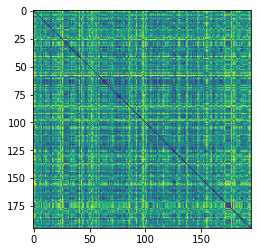

In [12]:
print(color_inv_sim_matrix.min(), color_inv_sim_matrix.max())
plt.imshow(color_inv_sim_matrix)

In [13]:
# # Get similarity matrix with cosine similarity
# color_sim_matrix_cosine = calc_color_distrib_similarity_matrix(color_distrs, sim_fn=cosine_similarity)
# color_inv_sim_matrix_cosine = 1 - color_sim_matrix_cosine

In [14]:
# Get similarity matrix with Lab
color_sim_matrix_Lab = calc_color_distrib_similarity_matrix(color_distrs, sim_fn=euclidean_similarity_Lab)
color_inv_sim_matrix_Lab = 1 - color_sim_matrix_Lab

100%|██████████| 195/195 [00:08<00:00, 21.88it/s]


In [15]:
################################ BEST SO FAR ################################
# Get symmetrical similarity matrix with Lab
color_sim_matrix_Lab_sym = calc_color_distrib_similarity_matrix_symmetrical(color_distrs, sim_fn=euclidean_similarity_Lab)
color_inv_sim_matrix_Lab_sym = 1 - color_sim_matrix_Lab_sym

100%|██████████| 195/195 [00:08<00:00, 22.15it/s]


In [16]:
# Get symmetrical similarity matrix with HSL
color_sim_matrix_HSL_sym = calc_color_distrib_similarity_matrix_symmetrical(color_distrs, sim_fn=HSL_similarity, percent_method="minimum")
color_inv_sim_matrix_HSL_sym = 1 - color_sim_matrix_HSL_sym

100%|██████████| 195/195 [00:08<00:00, 22.83it/s]


In [17]:
# Get symmetrical similarity matrix with HSL and percentage method "skewed"
color_sim_matrix_HSL_skewed_sym = calc_color_distrib_similarity_matrix_symmetrical(color_distrs, sim_fn=HSL_similarity, percent_method="skewed")
color_inv_sim_matrix_HSL_skewed_sym = 1 - color_sim_matrix_HSL_skewed_sym

100%|██████████| 195/195 [00:08<00:00, 22.74it/s]


In [18]:
# Get symmetrical similarity matrix with HSL and percentage method "uniform"
color_sim_matrix_HSL_uniform_sym = calc_color_distrib_similarity_matrix_symmetrical(color_distrs, sim_fn=HSL_similarity, percent_method="uniform")
color_inv_sim_matrix_HSL_uniform_sym = 1 - color_sim_matrix_HSL_uniform_sym

100%|██████████| 195/195 [00:08<00:00, 23.06it/s]


In [19]:
# # Get similarity matrix with different similarity function
# color_sim_matrix_old = calc_color_distrib_similarity_matrix(color_distrs, distr_sim_fn=calc_color_distrib_similarity_old)
# color_inv_sim_matrix_old = 1 - color_sim_matrix_old

In [ ]:
# # Get distance matrix
# color_dist_matrix = calc_color_distrib_distance_matrix(color_distrs)
# print(color_dist_matrix.min(), color_dist_matrix.max())

In [24]:
# Get distance matrix with Lab color space
color_dist_matrix_Lab = calc_color_distrib_distance_matrix(color_distrs, dist_fn=euclidean_distance_Lab)
print(color_dist_matrix_Lab.min(), color_dist_matrix_Lab.max())

100%|██████████| 195/195 [00:05<00:00, 34.78it/s]

0.0 1.0


In [25]:
def get_flag(flag_code):
    """Get the flag of a country by its code"""
    return Image.open(os.path.join(COUNTRIES_PATH, flag_code + '.png'))

In [26]:
# Check if each matrix is symmetric
print(np.allclose(color_inv_sim_matrix, color_inv_sim_matrix.T, atol=0.01))
print(np.allclose(color_inv_sim_matrix_Lab, color_inv_sim_matrix_Lab.T, atol=0.01))
print(np.allclose(color_inv_sim_matrix_Lab_sym, color_inv_sim_matrix_Lab_sym.T, atol=0.01))
print(np.allclose(color_inv_sim_matrix_HSL_sym, color_inv_sim_matrix_HSL_sym.T, atol=0.01))
print(np.allclose(color_inv_sim_matrix_HSL_skewed_sym, color_inv_sim_matrix_HSL_skewed_sym.T, atol=0.01))
print(np.allclose(color_inv_sim_matrix_HSL_uniform_sym, color_inv_sim_matrix_HSL_uniform_sym.T, atol=0.01))
print(np.allclose(color_dist_matrix_Lab, color_dist_matrix_Lab.T, atol=0.01))

False
False
True
True
True
True
True


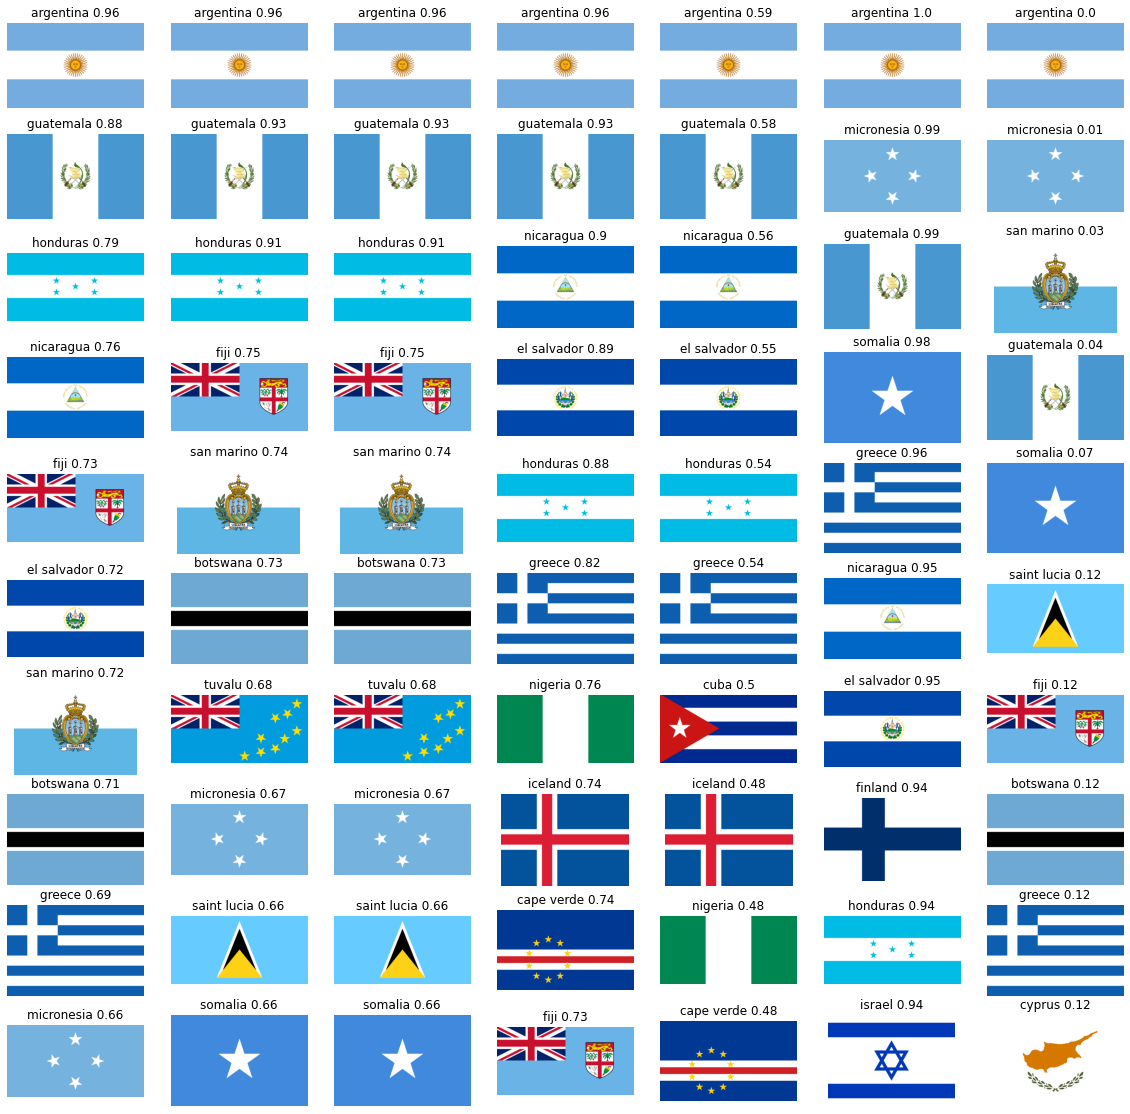

In [28]:
%matplotlib inline

# Plot sorted vertical list of flags by similarity to the reference flag
reference_flag = 'argentina'
reference_code = country2code[reference_flag]
amount = 10
sorted_flags_sim = sorted(color_distrs.keys(), key=lambda x: color_inv_sim_matrix[list(color_distrs.keys()).index(reference_code), list(color_distrs.keys()).index(x)])[:amount]
sorted_flags_sim_Lab = sorted(color_distrs.keys(), key=lambda x: color_inv_sim_matrix_Lab[list(color_distrs.keys()).index(reference_code), list(color_distrs.keys()).index(x)])[:amount]
sorted_flags_sim_Lab_sym = sorted(color_distrs.keys(), key=lambda x: color_inv_sim_matrix_Lab_sym[list(color_distrs.keys()).index(reference_code), list(color_distrs.keys()).index(x)])[:amount]
sorted_flags_sim_HSL_sym = sorted(color_distrs.keys(), key=lambda x: color_inv_sim_matrix_HSL_sym[list(color_distrs.keys()).index(reference_code), list(color_distrs.keys()).index(x)])[:amount]
sorted_flags_sim_HSL_skewed_sym = sorted(color_distrs.keys(), key=lambda x: color_inv_sim_matrix_HSL_skewed_sym[list(color_distrs.keys()).index(reference_code), list(color_distrs.keys()).index(x)])[:amount]
sorted_flags_sim_HSL_uniform_sym = sorted(color_distrs.keys(), key=lambda x: color_inv_sim_matrix_HSL_uniform_sym[list(color_distrs.keys()).index(reference_code), list(color_distrs.keys()).index(x)])[:amount]
sorted_flags_dist_Lab = sorted(color_distrs.keys(), key=lambda x: color_dist_matrix_Lab[list(color_distrs.keys()).index(reference_code), list(color_distrs.keys()).index(x)])[:amount]

fig, ax = plt.subplots(amount, 7, figsize=(20, 20))

def gen_title(flag_code, matrix):
    return code2country[flag_code] + ' ' + str(round(matrix[list(color_distrs.keys()).index(reference_code), list(color_distrs.keys()).index(flag_code)],2))

for i, flag in enumerate(sorted_flags_sim):
    ax[i,0].imshow(get_flag(flag))
    ax[i,0].set_title(gen_title(flag, color_sim_matrix))
    ax[i,0].axis('off')

for i, flag in enumerate(sorted_flags_sim_Lab):
    ax[i,1].imshow(get_flag(flag))
    ax[i,1].set_title(gen_title(flag, color_sim_matrix_Lab))
    ax[i,1].axis('off')

for i, flag in enumerate(sorted_flags_sim_Lab_sym):
    ax[i,2].imshow(get_flag(flag))
    ax[i,2].set_title(gen_title(flag, color_sim_matrix_Lab_sym))
    ax[i,2].axis('off')

for i, flag in enumerate(sorted_flags_sim_HSL_sym):
    ax[i,3].imshow(get_flag(flag))
    ax[i,3].set_title(gen_title(flag, color_sim_matrix_HSL_sym))
    ax[i,3].axis('off')

for i, flag in enumerate(sorted_flags_sim_HSL_skewed_sym):
    ax[i,4].imshow(get_flag(flag))
    ax[i,4].set_title(gen_title(flag, color_sim_matrix_HSL_skewed_sym))
    ax[i,4].axis('off')

for i, flag in enumerate(sorted_flags_sim_HSL_uniform_sym):
    ax[i,5].imshow(get_flag(flag))
    ax[i,5].set_title(gen_title(flag, color_sim_matrix_HSL_uniform_sym))
    ax[i,5].axis('off')

for i, flag in enumerate(sorted_flags_dist_Lab):
    ax[i,6].imshow(get_flag(flag))
    ax[i,6].set_title(gen_title(flag, color_dist_matrix_Lab))
    ax[i,6].axis('off')

plt.show()

In [ ]:
# Get verbose similarity between lebanon and liberia, using calc_color_distrib_similarity on verbose mode
flag2 = 'saint lucia'
flag1 = 'antigua and barbuda'
flag1_code = country2code[flag1]
flag2_code = country2code[flag2]

# sim_fn = euclidean_similarity_Lab
sim_fn = HSL_similarity

print('Similarity between {} and {} is {}'.format(flag1, flag2, calc_color_distrib_similarity(color_distrs[flag1_code], color_distrs[flag2_code], verbose=True, 
    sim_fn=sim_fn, percent_method="uniform")))

flag1 = 'bangladesh'
flag2 = 'brazil'
flag1_code = country2code[flag1]
flag2_code = country2code[flag2] 
print('Similarity between {} and {} is {}'.format(flag1, flag2, calc_color_distrib_similarity(color_distrs[flag1_code], color_distrs[flag2_code], verbose=True, 
    sim_fn=sim_fn)))

Things that don't make sense in Lab:
- argentinian blue is closer to white than blue
- french blue is as close to hungarian green as costa rican blue
- the blue orb of Brazil and red orb of Bangladesh are 0.79/1 similar??

question: Do different people (culturally) see colour the same way?
Personally I seem to remember the colours on the flag by grouping them into the main colours: red, white, blue, green, yellow, orange and black, and for example the kind of teal/aquamarine colour on the Bahamas flag falls into blue for me even though it's probably closer to some greens than some blues.

In [ ]:
%matplotlib widget

# # Make 3D plot of all colors in Lab_dict
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for color in Lab_dict:
#     coord = Lab_dict[color]
#     ax.scatter(coord[1], coord[2], coord[0], color=color)

#     # Label the axes
#     ax.set_xlabel('a (green-red)')
#     ax.set_ylabel('b (blue-yellow)')
#     ax.set_zlabel('L')
# plt.show()

# Make 2D plot of all colors in Lab_dict leaving out L
fig = plt.figure()
ax = fig.add_subplot(111)
for color in Lab_dict:
    coord = Lab_dict[color]
    ax.scatter(coord[1], coord[2], color=color)

    # Label the axes
    ax.set_xlabel('a (green-red)')
    ax.set_ylabel('b (blue-yellow)')

In [ ]:
# Make 3D plot of all colors for OKLab
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for color in Lab_dict:
    coord = OKLab_dict[color]
    ax.scatter(coord[1], coord[2], coord[0], color=color)

    # Label the axes
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('L')
plt.show()

In [ ]:
# Make 3D plot of all colors for RGB
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for color in Lab_dict:
    coord = color
    ax.scatter(coord[0], coord[1], coord[2], color=color)

    # label axes
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
plt.show()

In [ ]:
# # Make 3D plot of all colors for HSL
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for color in Lab_dict:
#     coord = HSL_dict[color]
#     ax.scatter(coord[0], coord[1], coord[2], color=color)

#     # label axes
#     ax.set_xlabel('H')
#     ax.set_ylabel('S')
#     ax.set_zlabel('L')
# plt.show()

# Make 2D plot of all colors for HSL leaving out L
fig = plt.figure()
ax = fig.add_subplot(111)
for color in Lab_dict:
    coord = HSL_dict[color]
    ax.scatter(coord[0], coord[1], color=color)

    # label axes
    ax.set_xlabel('H')
    ax.set_ylabel('S')

In [ ]:
def get_2d_coordinates(distances):
    # Create an MDS object with the desired number of dimensions
    n_dimensions = 2  # Set the desired number of dimensions (in this case, 2)
    mds = MDS(n_components=n_dimensions)

    # Perform dimensionality reduction
    coordinates = mds.fit_transform(distances)

    # The 'coordinates' variable now contains the 2D coordinates of the flags

    # You can access the x and y coordinates separately
    x = coordinates[:, 0]
    y = coordinates[:, 1]

    return x, y

In [ ]:
def cosine_dissimilarity(color1, color2):
    """Doing something wrong"""
    return 2 - (cosine_similarity(color1, color2)+1)

# dist_fn = euclidean_distance
# dist_fn = cosine_dissimilarity
dist_fn = HSL_dist
space_fn = lambda x: np.array(x)
# space_fn = lambda x: Lab_dict[x]
# space_fn = lambda x: OKLab_dict[x]
# space_fn = lambda x: HSL_dict[x]

# Make pairwise distance matrix between all colors in Lab_dict
dist_matrix = np.zeros((len(Lab_dict), len(Lab_dict)))
for i, color1 in enumerate(Lab_dict):
    for j, color2 in enumerate(Lab_dict):
        Lab_dist_matrix[i,j] = dist_fn(space_fn(color1), space_fn(color2))

# Plot 2D coordinates of all colors in Lab_dict
x, y = get_2d_coordinates(Lab_dist_matrix)
fig = plt.figure()
ax = fig.add_subplot(111)

# Each dot is a color and thus colored according to its color
for i, color in enumerate(Lab_dict):
    ax.scatter(x[i], y[i], color=color)

# Label the axes
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()